#### Data Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from FinancialMachineLearning.features.concurrency import *
from FinancialMachineLearning.multiprocess import multiprocess

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/fast_ewma.py:5: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((float64[:], int64), nopython = False, nogil = True)


In [2]:
import os
os.chdir('..')
os.chdir('..')
os.getcwd()

'/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning'

In [3]:
dollar = pd.read_csv('./Data/dollar_IVEfuture.csv', index_col = 0, parse_dates = True)
dollar = dollar[~dollar.index.duplicated(keep = 'first')]
dollar

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2009-09-28 09:46:34,80,50.79,51.070,50.7100,51.07,20044,13264,80,1.020027e+06
2009-09-28 09:52:47,142,51.07,51.148,51.0500,51.13,21024,19774,62,1.073986e+06
2009-09-28 09:54:38,201,51.14,51.150,51.1290,51.13,19951,6951,59,1.020145e+06
2009-09-28 09:55:26,243,51.13,51.150,51.1300,51.14,19652,18052,42,1.004999e+06
2009-09-28 10:02:48,339,51.14,51.260,51.0800,51.25,19943,11354,96,1.020512e+06
...,...,...,...,...,...,...,...,...,...
2023-09-14 15:54:32,10930083,162.98,163.060,162.9654,162.98,6186,3983,39,1.008408e+06
2023-09-14 15:59:20,10930131,162.99,163.040,162.9299,163.04,7158,4629,48,1.166735e+06
2023-09-14 15:59:39,10930171,163.04,163.050,162.9900,163.00,6316,3266,40,1.029639e+06


#### EWMA volatility

In [4]:
from FinancialMachineLearning.features.volatility import daily_volatility
vol = daily_volatility(dollar.close, lookback = 100)

#### CUSUM Filtering

In [5]:
from FinancialMachineLearning.filter.filter import cusum_filter
cusum_events = cusum_filter(dollar.close, threshold = vol.mean())

#### add Vertical barrier

In [6]:
from FinancialMachineLearning.labeling.labeling import *
vertical_barrier = add_vertical_barrier(cusum_events, dollar['close'], num_days = 5)

#### Triple Barrier Methods

In [7]:
triple_barrier_events = get_events(close = dollar['close'],
                                   t_events = cusum_events[34:],
                                   pt_sl = [1, 1],
                                   target = vol,
                                   min_ret = 0.01,
                                   num_threads = 1,
                                   vertical_barrier_times = vertical_barrier,
                                   side_prediction = None)
triple_barrier_events

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/labeling/labeling.py:17: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for loc, vertical_barrier in events_['t1'].fillna(close.index[-1]).iteritems():
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


,t1,trgt,pt,sl
2009-10-02 09:31:33,2009-10-02 10:35:54,0.010011,1,1
2009-10-02 09:44:59,2009-10-02 10:35:54,0.010268,1,1
2009-10-02 09:53:14,2009-10-05 09:59:08,0.010379,1,1
2009-10-02 10:01:56,2009-10-05 09:59:08,0.010430,1,1
2009-10-02 10:09:13,2009-10-05 09:59:08,0.010453,1,1
...,...,...,...,...
2023-05-08 15:16:20,2023-05-10 13:27:11,0.010701,1,1
2023-05-08 15:16:37,2023-05-12 12:21:00,0.010595,1,1
2023-05-08 15:36:39,2023-05-10 13:27:11,0.010387,1,1
2023-05-08 15:47:11,2023-05-10 13:27:11,0.010283,1,1


#### Concurrency

In [8]:
num_threads = 1
num_conc_events = multiprocess.mp_pandas_obj(concurrent_events, ('molecule', triple_barrier_events.index), num_threads, close_series_index = dollar.close.index, label_endtime = triple_barrier_events['t1'])

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/concurrency.py:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t_in, t_out in label_endtime.iteritems():
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:42: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df0 = pd.Series()
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:47: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df0 = df0.append(i)


In [9]:
num_conc_events = num_conc_events.reindex(dollar.close.index).fillna(0)

#### Uniqueness

In [10]:
avg_unique = multiprocess.mp_pandas_obj(average_uniqueness, ('molecule', triple_barrier_events.index), num_threads, 
                                 label_endtime = triple_barrier_events['t1'], num_conc_events = num_conc_events)
avg_unique

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/concurrency.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wght = pd.Series(index=molecule)
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/concurrency.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t_in, t_out in label_endtime.loc[wght.index].iteritems():
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:42: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df0 = pd.Series()
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/multiprocess.py:47: F

2009-10-02 09:31:33    0.275361
2009-10-02 09:44:59    0.202897
2009-10-02 09:53:14    0.134853
2009-10-02 10:01:56    0.129891
2009-10-02 10:09:13    0.126811
                         ...   
2023-05-08 15:16:20    0.020295
2023-05-08 15:16:37    0.035904
2023-05-08 15:36:39    0.020236
2023-05-08 15:47:11    0.020225
2023-05-08 15:54:13    0.020222
Length: 30053, dtype: float64

#### Hasbrouck's Lambda

In [11]:
from FinancialMachineLearning.features.microstructure import *
lambda_feature = Lambda(dollar['close'], dollar['volume'])

In [12]:
aggressor = tick_rule(dollar['close'])
aggressor

date_time
2009-09-28 09:46:34    1.0
2009-09-28 09:52:47    1.0
2009-09-28 09:54:38    1.0
2009-09-28 09:55:26    1.0
2009-09-28 10:02:48    1.0
                      ... 
2023-09-14 15:54:32   -1.0
2023-09-14 15:59:20    1.0
2023-09-14 15:59:39   -1.0
2023-09-14 15:59:59   -1.0
2023-09-14 16:00:00   -1.0
Length: 215833, dtype: float64

In [13]:
hasbrouck_lambda = lambda_feature.hasbrouck(signs = aggressor)
hasbrouck_lambda

date_time
2009-09-28 09:46:34             NaN
2009-09-28 09:52:47    8.097906e-06
2009-09-28 09:54:38    0.000000e+00
2009-09-28 09:55:26    1.395013e-06
2009-09-28 10:02:48    1.521493e-05
                           ...     
2023-09-14 15:54:32    2.340141e-06
2023-09-14 15:59:20    4.350520e-06
2023-09-14 15:59:39    3.087437e-06
2023-09-14 15:59:59    1.554124e-06
2023-09-14 16:00:00    3.416387e-07
Length: 215833, dtype: float64

#### Fractionally differenciated Features

In [14]:
from FinancialMachineLearning.features.fracdiff import FractionalDifferentiatedFeatures
frac_dollar = FractionalDifferentiatedFeatures.fracDiff_FFD(dollar.iloc[:,4:5], 0.2)

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/features/fracdiff.py:34: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()


In [15]:
frac_dollar

,close
2010-04-29 10:26:57,10.476812
2010-04-29 11:09:15,10.507715
2010-04-29 11:26:03,10.464420
2010-04-29 11:34:28,10.488812
2010-04-29 11:44:01,10.540226
...,...
2023-09-14 15:54:32,28.022345
2023-09-14 15:59:20,28.081668
2023-09-14 15:59:39,28.025730
2023-09-14 15:59:59,28.004278


#### VPIN

In [16]:
from FinancialMachineLearning.barsampling.standard_data_structures import volume_bar

def buy_volume(df):
    tick_signs = tick_rule(df['price'])
    return (df['volume'] * (tick_signs > 0)).sum()
def sell_volume(df):
    tick_signs = tick_rule(df['price'])
    return (df['volume'] * (tick_signs < 0)).sum()

In [17]:
from FinancialMachineLearning.barsampling.bar_feature import BarFeature
buy_volume_feature = BarFeature(name = 'buy_volume', function = buy_volume)
sell_volume_feature = BarFeature(name = 'sell_volume', function = sell_volume)

In [18]:
#bars = volume_bar('./Data/IVEfuture.txt', additional_features = [buy_volume_feature, sell_volume_feature])
#vol_thres = 10000
#vpin_series = vpin(bars['buy_volume'], bars['sell_volume'], vol_thres, 5)

#### Labeling

In [19]:
labels = meta_labeling(triple_barrier_events, dollar['close'])
labels

,ret,trgt,bin
2009-10-02 09:31:33,0.011168,0.010011,1
2009-10-02 09:44:59,0.010552,0.010268,1
2009-10-02 09:53:14,0.012738,0.010379,1
2009-10-02 10:01:56,0.014995,0.010430,1
2009-10-02 10:09:13,0.013896,0.010453,1
...,...,...,...
2023-05-08 15:16:20,-0.010951,0.010701,-1
2023-05-08 15:16:37,-0.011112,0.010595,-1
2023-05-08 15:36:39,-0.010391,0.010387,-1
2023-05-08 15:47:11,-0.011105,0.010283,-1


#### Feature Matrix

In [20]:
matrix = pd.DataFrame()
matrix = pd.concat([dollar.close, labels['ret'], frac_dollar, vol, num_conc_events, avg_unique, hasbrouck_lambda, labels['bin']], axis = 1)
matrix.columns = ['price','return','fracdiff','volatility','concurrency','uniqueness','hasbrouck','side']
matrix = matrix.dropna()
matrix

,price,return,fracdiff,volatility,concurrency,uniqueness,hasbrouck,side
2010-04-29 10:26:57,58.2801,-0.011465,10.476812,0.010964,20.0,0.074445,0.000015,-1.0
2010-04-29 11:09:15,58.3600,-0.012819,10.507715,0.011247,7.0,0.075186,0.000010,-1.0
2010-04-29 11:34:28,58.4100,-0.013664,10.488812,0.011638,5.0,0.067364,0.000007,-1.0
2010-04-29 11:44:01,58.4900,-0.012306,10.540226,0.011979,6.0,0.066014,0.000010,-1.0
2010-04-29 12:00:06,58.4498,-0.014335,10.465450,0.012262,7.0,0.059366,0.000005,-1.0
...,...,...,...,...,...,...,...,...
2023-05-08 15:16:20,152.1563,-0.010951,26.030479,0.010701,46.0,0.020295,0.000004,-1.0
2023-05-08 15:16:37,152.0900,-0.011112,25.963539,0.010595,47.0,0.035904,0.000005,-1.0
2023-05-08 15:36:39,152.0701,-0.010391,25.952489,0.010387,48.0,0.020236,0.000002,-1.0
2023-05-08 15:47:11,152.1800,-0.011105,26.065165,0.010283,49.0,0.020225,0.000009,-1.0


#### Meta Labeling

In [21]:
triple_barrier_events['side'] = labels.bin
triple_barrier_events

,t1,trgt,pt,sl,side
2009-10-02 09:31:33,2009-10-02 10:35:54,0.010011,1,1,1
2009-10-02 09:44:59,2009-10-02 10:35:54,0.010268,1,1,1
2009-10-02 09:53:14,2009-10-05 09:59:08,0.010379,1,1,1
2009-10-02 10:01:56,2009-10-05 09:59:08,0.010430,1,1,1
2009-10-02 10:09:13,2009-10-05 09:59:08,0.010453,1,1,1
...,...,...,...,...,...
2023-05-08 15:16:20,2023-05-10 13:27:11,0.010701,1,1,-1
2023-05-08 15:16:37,2023-05-12 12:21:00,0.010595,1,1,-1
2023-05-08 15:36:39,2023-05-10 13:27:11,0.010387,1,1,-1
2023-05-08 15:47:11,2023-05-10 13:27:11,0.010283,1,1,-1


In [22]:
meta_labels = meta_labeling(triple_barrier_events, dollar['close'])
meta_labels

,ret,trgt,bin,side
2009-10-02 09:31:33,0.011168,0.010011,1,1
2009-10-02 09:44:59,0.010552,0.010268,1,1
2009-10-02 09:53:14,0.012738,0.010379,1,1
2009-10-02 10:01:56,0.014995,0.010430,1,1
2009-10-02 10:09:13,0.013896,0.010453,1,1
...,...,...,...,...
2023-05-08 15:16:20,0.011072,0.010701,1,-1
2023-05-08 15:16:37,0.011237,0.010595,1,-1
2023-05-08 15:36:39,0.010500,0.010387,1,-1
2023-05-08 15:47:11,0.011230,0.010283,1,-1


In [23]:
matrix['label'] = meta_labels['bin']
matrix

,price,return,fracdiff,volatility,concurrency,uniqueness,hasbrouck,side,label
2010-04-29 10:26:57,58.2801,-0.011465,10.476812,0.010964,20.0,0.074445,0.000015,-1.0,1
2010-04-29 11:09:15,58.3600,-0.012819,10.507715,0.011247,7.0,0.075186,0.000010,-1.0,1
2010-04-29 11:34:28,58.4100,-0.013664,10.488812,0.011638,5.0,0.067364,0.000007,-1.0,1
2010-04-29 11:44:01,58.4900,-0.012306,10.540226,0.011979,6.0,0.066014,0.000010,-1.0,1
2010-04-29 12:00:06,58.4498,-0.014335,10.465450,0.012262,7.0,0.059366,0.000005,-1.0,1
...,...,...,...,...,...,...,...,...,...
2023-05-08 15:16:20,152.1563,-0.010951,26.030479,0.010701,46.0,0.020295,0.000004,-1.0,1
2023-05-08 15:16:37,152.0900,-0.011112,25.963539,0.010595,47.0,0.035904,0.000005,-1.0,1
2023-05-08 15:36:39,152.0701,-0.010391,25.952489,0.010387,48.0,0.020236,0.000002,-1.0,1
2023-05-08 15:47:11,152.1800,-0.011105,26.065165,0.010283,49.0,0.020225,0.000009,-1.0,1


#### Meta Model

In [24]:
from sklearn.model_selection import train_test_split
X = matrix.iloc[:,[2,3,4,5,6]]
y = matrix.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 1000,
                            criterion = 'entropy', 
                            random_state = 42,
                            class_weight = 'balanced_subsample', 
                            ccp_alpha = 0.001,
                            min_weight_fraction_leaf = 0.05,
                            max_samples = matrix['uniqueness'].mean(),
                            max_features = 20)
model = rf.fit(X_train, y_train)

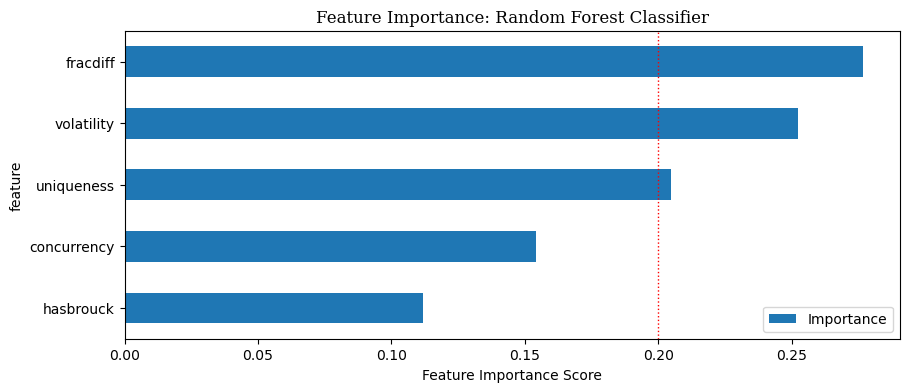

In [27]:
title = 'Feature Importance: Random Forest Classifier'
figsize = (10, 4)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending = False, inplace = True)
feat_imp = feat_imp

feat_imp.sort_values(by = 'Importance', inplace = True)
feat_imp = feat_imp.set_index('feature', drop = True)
feat_imp.plot.barh(figsize = figsize)
plt.axvline(1. / feat_imp.shape[0], linewidth = 1, color='r', linestyle='dotted')
plt.xlabel('Feature Importance Score')
plt.title(title, fontsize = 12, fontfamily = 'Serif')
plt.show()

              precision    recall  f1-score   support

    no trade       0.15      0.30      0.20      1138
       trade       0.88      0.75      0.81      7687

    accuracy                           0.70      8825
   macro avg       0.52      0.53      0.51      8825
weighted avg       0.79      0.70      0.73      8825


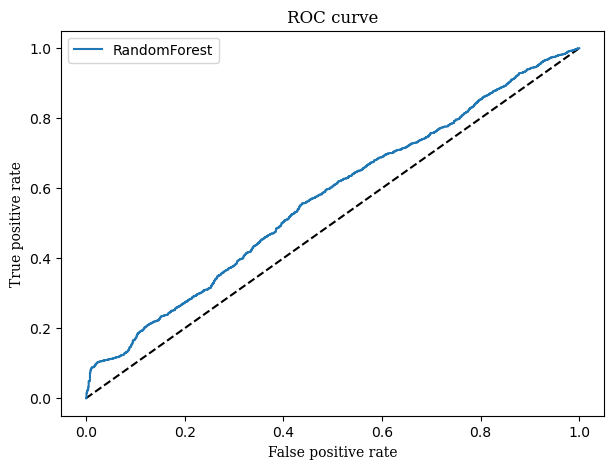

In [28]:
fit = rf.fit(X_train, y_train)
y_pred_rf = fit.predict_proba(X_test)[:, 1]
y_pred = fit.predict(X_test)
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names = ['no trade',' trade']))

plt.figure(figsize = (7,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc, tpr_bc, label = 'RandomForest')
plt.grid(False)
plt.xlabel('False positive rate', fontfamily = 'Serif')
plt.ylabel('True positive rate', fontfamily = 'Serif')
plt.title('ROC curve', fontsize = 12, fontfamily = 'Serif')
plt.legend(loc = 'best')
plt.show()

In [29]:
backtest = pd.DataFrame()
backtest['Predict'] = model.predict(X_test)
backtest['Actual'] = y_test.values
backtest['Betting Size'] = model.predict_proba(X_test)[:,1]
backtest['Return'] = np.log(matrix.price / matrix.price.shift(1))[-8825:].values
backtest['Backtest'] = model.predict_proba(X_test)[:,1] * backtest['Return'].values
backtest.index = X_test.index
backtest

,Predict,Actual,Betting Size,Return,Backtest
2020-09-03 13:30:00,1,1,0.587535,0.002239,0.001316
2020-09-03 13:33:51,1,1,0.609883,-0.003274,-0.001997
2020-09-03 13:39:20,1,1,0.525309,-0.000777,-0.000408
2020-09-03 13:45:09,1,1,0.550905,0.000950,0.000523
2020-09-03 13:52:55,0,1,0.479428,0.000173,0.000083
...,...,...,...,...,...
2023-05-08 15:16:20,1,1,0.550160,-0.000340,-0.000187
2023-05-08 15:16:37,1,1,0.551641,-0.000436,-0.000240
2023-05-08 15:36:39,1,1,0.582746,-0.000131,-0.000076
2023-05-08 15:47:11,1,1,0.632170,0.000722,0.000457


Text(0.5, 1.0, 'Becktesting Machine Learning Model(Apple)')

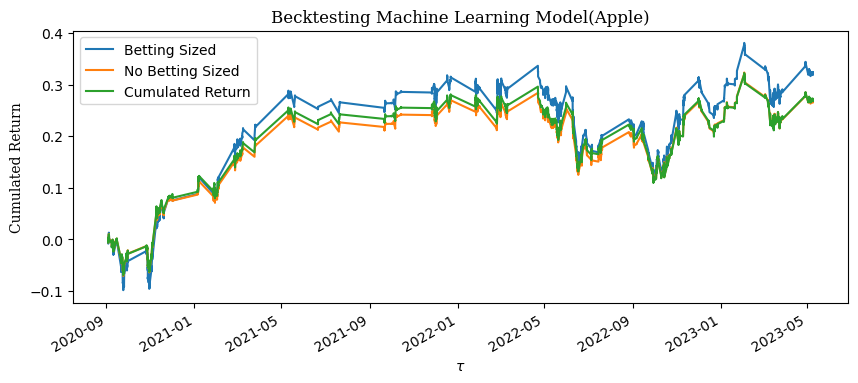

In [30]:
plt.figure(figsize = (10,4))
(backtest[backtest['Predict'] == 1]['Backtest']*2).cumsum().plot(label = 'Betting Sized')
backtest[backtest['Predict'] == 1]['Return'].cumsum().plot(label = 'No Betting Sized')
backtest['Return'].cumsum().plot(label = 'Cumulated Return')
plt.legend()
plt.grid(False)
plt.xlabel(r'$\tau$')
plt.ylabel(r'Cumulated Return', fontfamily = 'Serif')
plt.title('Becktesting Machine Learning Model(Apple)', fontsize = 12, fontfamily = 'Serif')